In [1]:
!pip -q install pandas numpy matplotlib pyarrow fastparquet
import os,json,warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',120)
pd.set_option('display.width',200)
plt.rcParams['figure.figsize']=(10,5)

# Rutas de trabajo
RAW_JSON_PATH='/content/TelecomX_Data.json'
BRONZE_PATH='/content/telecomx_bronze.parquet'
SILVER_PATH='/content/telecomx_silver.parquet'
GOLD_PATH='/content/telecomx_churn_gold.csv'
REPORT_PATH='/content/TelecomX_Final_Report.md'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00


In [2]:
def _flatten_records(obj):
    """Devuelve lista de dicts desde JSON en distintos formatos."""
    if isinstance(obj,list):
        return obj
    if isinstance(obj,dict):
        # Busca contenedores de datos comunes
        for key in ['data','results','items','records']:
            if key in obj and isinstance(obj[key],list):
                return obj[key]
        return [obj]
    return []

def normalize_colnames(cols):
    """Normaliza nombres de columnas: espacios y puntos a guion bajo."""
    out=[]
    for c in cols:
        c2=c.strip().replace(' ','_').replace('-','_').replace('.','_')
        out.append(c2)
    return out

# Leer el JSON
with open(RAW_JSON_PATH,'r',encoding='utf-8') as f:
    raw=json.load(f)

records=_flatten_records(raw)
if not records:
    raise ValueError("No se pudieron extraer registros del JSON.")

# Convertir a DataFrame y normalizar columnas
df_bronze=pd.json_normalize(records,max_level=1)
df_bronze.columns=normalize_colnames(df_bronze.columns)

# Guardar como BRONZE (datos crudos, sin limpieza)
try:
    df_bronze.to_parquet(BRONZE_PATH)
except Exception:
    # Fallback a CSV si el motor de parquet no está disponible
    BRONZE_PATH=BRONZE_PATH.replace('.parquet','.csv')
    df_bronze.to_csv(BRONZE_PATH,index=False)

print("BRONZE listo →",BRONZE_PATH,"| Shape:",df_bronze.shape)
df_bronze.head()

BRONZE listo → /content/telecomx_bronze.parquet | Shape: (7267, 20)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,"{'Monthly': 65.6, 'Total': '593.3'}"
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,"{'Monthly': 59.9, 'Total': '542.4'}"
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,"{'Monthly': 73.9, 'Total': '280.85'}"
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"{'Monthly': 98.0, 'Total': '1237.85'}"
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,"{'Monthly': 83.9, 'Total': '267.4'}"


In [3]:
def coerce_numeric(series):
    """Convierte una serie a tipo numérico, manejando comas y espacios."""
    if series.dtype==object:
        series=series.astype(str).str.replace(',','',regex=False).str.strip()
    return pd.to_numeric(series,errors='coerce')

def tidy_binary(series):
    """Estandariza valores binarios comunes (Yes/No, True/False, etc.) a 0/1."""
    s=series.astype(str).str.lower().str.strip()
    s=s.replace('',np.nan)
    m={'yes':1,'y':1,'true':1,'1':1,'si':1,'sí':1,
       'no':0,'n':0,'false':0,'0':0}
    s_mapped=s.map(m)
    s_numeric=pd.to_numeric(series,errors='coerce')
    s_combined=s_mapped.combine_first(s_numeric)
    try:
        return s_combined.astype('Int64')
    except ValueError:
        return s_combined

def basic_cleaning(df):
    df2=df.copy()

    # Renombrar columnas de cobros para unificarlas
    rename_map={'Charges_Monthly':'Charges_Monthly','Charges_Total':'Charges_Total',
                'MonthlyCharges':'Charges_Monthly','TotalCharges':'Charges_Total'}
    for k,v in list(rename_map.items()):
        if k in df2.columns and v not in df2.columns:
            df2.rename(columns={k:v},inplace=True)

    if 'account_Charges' in df2.columns:
        df2=df2.drop(columns=['account_Charges'])

    # Tipificación de columnas numéricas
    for col in ['tenure','Charges_Monthly','Charges_Total','SeniorCitizen']:
        if col in df2.columns:
            df2[col]=coerce_numeric(df2[col])

    # Estandarización de columnas binarias a 0/1
    binary_cols=['Churn','SeniorCitizen','Partner','Dependents','PhoneService',
                 'MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                 'TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
    for col in binary_cols:
        if col in df2.columns:
            if col=='Churn':
                df2[col]=tidy_binary(df2[col])
                df2[col]=df2[col].apply(lambda x: x if x in [0,1,np.nan] else np.nan).fillna(0).astype(int)
            elif col=='SeniorCitizen':
                if pd.api.types.is_numeric_dtype(df2[col]):
                    df2[col]=df2[col].fillna(0).astype(int)
                else:
                    df2[col]=tidy_binary(df2[col]).fillna(0).astype(int)
            else:
                tmp=tidy_binary(df2[col])
                if pd.api.types.is_integer_dtype(tmp):
                    df2[col]=tmp.apply(lambda x: x if x in [0,1,np.nan] else np.nan).astype('Int64')
                elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
                    df2[col]=df2[col].astype('category')

    # Tipificación de columnas categóricas
    for col in ['gender','InternetService','Contract','PaymentMethod']:
        if col in df2.columns:
            df2[col]=df2[col].astype('category')

    # Imputación de nulos (mediana para numéricos, moda para categóricos)
    num_cols=df2.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols=df2.select_dtypes(include=['object','category']).columns.tolist()
    for c in num_cols:
        if df2[c].isna().any():
            median_val=df2[c].median()
            if pd.notna(median_val):
                df2[c]=df2[c].fillna(median_val)
    for c in cat_cols:
        if df2[c].isna().any():
            mode_val=df2[c].mode()
            if not mode_val.empty:
                df2[c]=df2[c].fillna(mode_val.iloc[0])

    # Creación de variable: diferencia entre cobro total real y esperado
    if {'Charges_Monthly','tenure','Charges_Total'}.issubset(df2.columns):
        if pd.api.types.is_numeric_dtype(df2['Charges_Monthly']) and \
           pd.api.types.is_numeric_dtype(df2['tenure']) and \
           pd.api.types.is_numeric_dtype(df2['Charges_Total']):
            expected=(df2['Charges_Monthly']*df2['tenure']).round(2)
            df2['TotalCharges_Delta']=(df2['Charges_Total']-expected).round(2)

    # Eliminar duplicados exactos
    if df2.duplicated().sum():
        df2=df2.drop_duplicates()

    return df2

df_silver=basic_cleaning(df_bronze)

# Guardar como SILVER (dataset limpio y preparado)
try:
    df_silver.to_parquet(SILVER_PATH)
except Exception:
    SILVER_PATH=SILVER_PATH.replace('.parquet','.csv')
    df_silver.to_csv(SILVER_PATH,index=False)

print("SILVER listo →",SILVER_PATH,"| Shape:",df_silver.shape)
df_silver.head()

SILVER listo → /content/telecomx_silver.parquet | Shape: (7267, 19)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check


In [4]:
# Exporta un CSV limpio (GOLD)
df_silver.to_csv(GOLD_PATH,index=False)
print("GOLD exportado →",GOLD_PATH,"| Shape:",df_silver.shape)

GOLD exportado → /content/telecomx_churn_gold.csv | Shape: (7267, 19)


Shape: (7267, 19)

Tipos:
 customerID                   object
Churn                         int64
customer_gender              object
customer_SeniorCitizen        int64
customer_Partner             object
customer_Dependents          object
customer_tenure               int64
phone_PhoneService           object
phone_MultipleLines          object
internet_InternetService     object
internet_OnlineSecurity      object
internet_OnlineBackup        object
internet_DeviceProtection    object
internet_TechSupport         object
internet_StreamingTV         object
internet_StreamingMovies     object
account_Contract             object
account_PaperlessBilling     object
account_PaymentMethod        object
dtype: object

Nulos por columna (top 20):
 customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents          0
customer_tenure              0
phone_PhoneService          

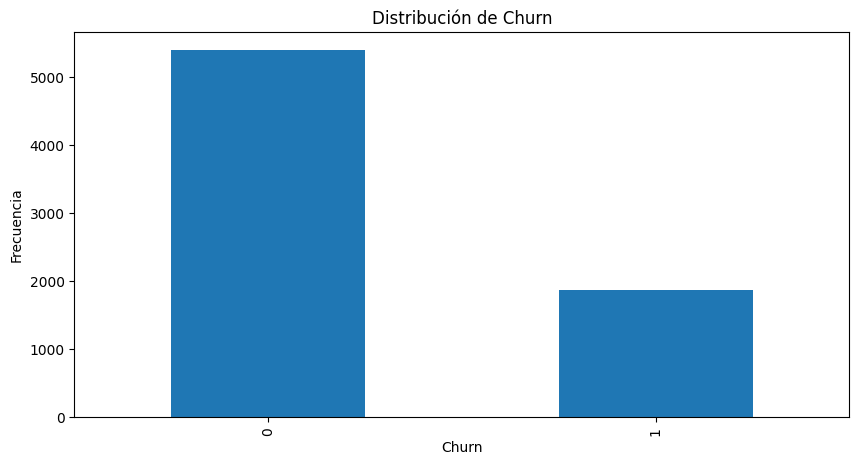


Top (categorías):


,feature,level,churn_rate,n,lift
39,account_PaymentMethod,Electronic check,0.438037,2445,1.703164
32,account_Contract,Month-to-month,0.413233,4005,1.606724
12,internet_InternetService,Fiber optic,0.405566,3198,1.576912
14,internet_OnlineSecurity,No,0.404933,3608,1.574452
23,internet_TechSupport,No,0.403685,3582,1.569598
17,internet_OnlineBackup,No,0.387492,3182,1.506637
20,internet_DeviceProtection,No,0.379030,3195,1.473734
29,internet_StreamingMovies,No,0.326829,2870,1.270770
26,internet_StreamingTV,No,0.325276,2896,1.264731
36,account_PaperlessBilling,Yes,0.324751,4311,1.262687



Top (numéricos por bins):


,feature,bin,churn_rate,n,lift
1,customer_tenure,"(-0.001, 6.0]",0.510417,1536,1.984590
2,customer_tenure,"(6.0, 20.0]",0.325436,1435,1.265350
0,customer_SeniorCitizen,"(-0.001, 1.0]",0.257190,7267,1.000000
3,customer_tenure,"(20.0, 40.0]",0.216942,1452,0.843509
4,customer_tenure,"(40.0, 60.0]",0.150754,1393,0.586157
5,customer_tenure,"(60.0, 72.0]",0.064094,1451,0.249208


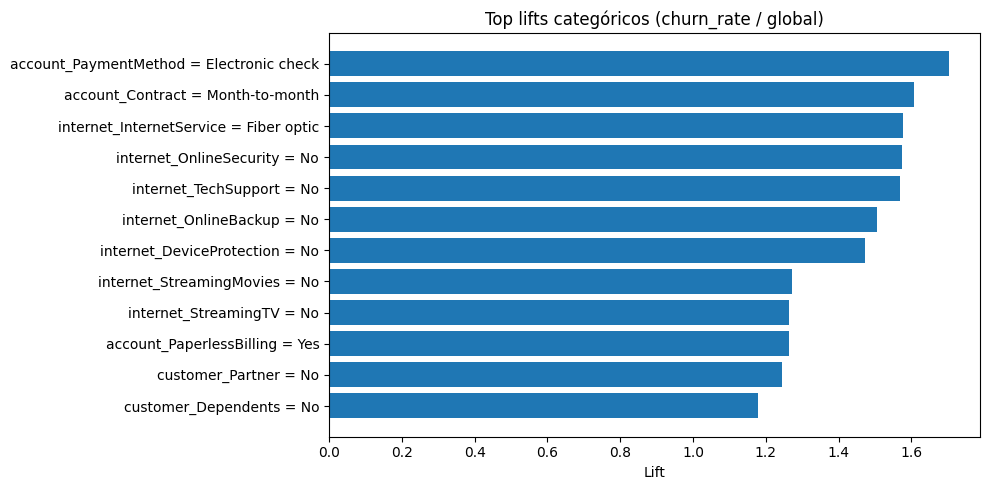

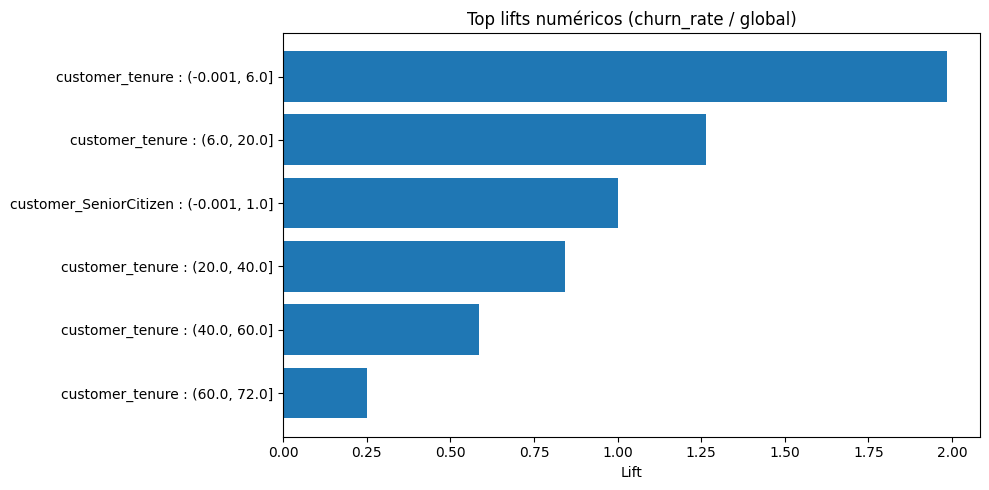

In [5]:
# Funciones auxiliares de EDA
def profile(df):
    print("Shape:",df.shape)
    print("\nTipos:\n",df.dtypes)
    print("\nNulos por columna (top 20):\n",df.isna().sum().sort_values(ascending=False).head(20))
    print("\nDuplicados:",df.duplicated().sum())

def churn_rate(df,target='Churn'):
    if target not in df.columns:
        raise ValueError(f"No se encontró la columna de target '{target}'.")
    return float(df[target].mean())

def lifts_by_category(df,target='Churn',min_count=30,max_card=30):
    base=churn_rate(df,target)
    cat_cols=df.select_dtypes(include=['object','category']).columns.tolist()
    out=[]
    for col in cat_cols:
        if df[col].nunique(dropna=True)>max_card:
            continue
        tmp=df.groupby(col,dropna=False)[target].agg(['mean','count']).rename(columns={'mean':'churn_rate','count':'n'}).reset_index()
        tmp=tmp[tmp['n']>=min_count]
        if tmp.empty:
            continue
        tmp['lift']=tmp['churn_rate']/(base if base>0 else 1)
        tmp.insert(0,'feature',col)
        tmp.rename(columns={col:'level'},inplace=True)
        out.append(tmp)
    if out:
        return pd.concat(out,ignore_index=True).sort_values('lift',ascending=False)
    return pd.DataFrame(columns=['feature','level','n','churn_rate','lift'])

def lifts_by_numeric(df,target='Churn',n_bins=5,min_count=30):
    base=churn_rate(df,target)
    num_cols=df.select_dtypes(include=[np.number]).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)
    out=[]
    for col in num_cols:
        # Evitar columnas derivadas auxiliares
        if col.lower().startswith('totalcharges_delta'):
            continue
        try:
            b=pd.qcut(df[col],q=n_bins,duplicates='drop')
        except Exception:
            continue
        tmp=df.groupby(b,dropna=False)[target].agg(['mean','count']).rename(columns={'mean':'churn_rate','count':'n'}).reset_index()
        tmp=tmp[tmp['n']>=min_count]
        if tmp.empty:
            continue
        tmp['lift']=tmp['churn_rate']/(base if base>0 else 1)
        tmp.insert(0,'feature',col)
        tmp.rename(columns={col:'bin'},inplace=True)
        out.append(tmp)
    if out:
        return pd.concat(out,ignore_index=True).sort_values('lift',ascending=False)
    return pd.DataFrame(columns=['feature','bin','n','churn_rate','lift'])

def plot_target_distribution(df,target='Churn'):
    vc=df[target].value_counts().sort_index()
    plt.figure()
    vc.plot(kind='bar')
    plt.title(f'Distribución de {target}')
    plt.xlabel(target)
    plt.ylabel('Frecuencia')
    plt.show()

def plot_top_lifts_cat(cat_lifts,top=12):
    if cat_lifts is None or cat_lifts.empty:
        print("Sin resultados categóricos suficientes.")
        return
    t=cat_lifts.head(top).copy()
    labels=t['feature'].astype(str)+" = "+t['level'].astype(str)
    plt.figure()
    plt.barh(labels.iloc[::-1],t['lift'].iloc[::-1])
    plt.title('Top lifts categóricos (churn_rate / global)')
    plt.xlabel('Lift')
    plt.tight_layout()
    plt.show()

def plot_top_lifts_num(num_lifts,top=12):
    if num_lifts is None or num_lifts.empty:
        print("Sin resultados numéricos suficientes.")
        return
    t=num_lifts.head(top).copy()
    labels=t['feature'].astype(str)+" : "+t['bin'].astype(str)
    plt.figure()
    plt.barh(labels.iloc[::-1],t['lift'].iloc[::-1])
    plt.title('Top lifts numéricos (churn_rate / global)')
    plt.xlabel('Lift')
    plt.tight_layout()
    plt.show()

# EDA
profile(df_silver)
global_rate=churn_rate(df_silver,'Churn')
print(f"\nTasa global de churn = {global_rate:.3f}")
plot_target_distribution(df_silver,'Churn')

cat_lifts=lifts_by_category(df_silver,'Churn',min_count=30,max_card=40)
num_lifts=lifts_by_numeric(df_silver,'Churn',n_bins=5,min_count=30)

print("\nTop (categorías):")
display(cat_lifts.head(20))
print("\nTop (numéricos por bins):")
display(num_lifts.head(20))

plot_top_lifts_cat(cat_lifts,top=12)
plot_top_lifts_num(num_lifts,top=12)

In [6]:
def guess_reason(feature,level):
    """Heurística para proponer posibles razones de churn según la variable."""
    f=feature.lower()
    lv=str(level).lower()
    if f=='contract' and 'month' in lv:
        return "Contrato mes a mes → baja barrera de salida / poca fidelización."
    if f=='paymentmethod' and 'electronic' in lv:
        return "Pagos electrónicos pueden correlacionar con mayor sensibilidad a variaciones de precio."
    if f=='techsupport' and lv in ['no','0','false']:
        return "Ausencia de soporte técnico → peor experiencia ante fallas."
    if f=='internetservice' and 'fiber' in lv:
        return "Planes de mayor costo/expectativas; posible insatisfacción precio/valor."
    if f=='onlinesecurity' and lv in ['no','0','false']:
        return "Servicios de seguridad ausentes → percepción de servicio incompleto."
    return "Segmento con propensión superior al promedio; revisar precios/soporte."

def build_report(df,cat_lifts,num_lifts,path,target='Churn',top_k=10):
    n_rows,n_cols=df.shape
    n_missing=int(df.isna().sum().sum())
    dups=int(df.duplicated().sum())
    base=churn_rate(df,target)

    # Selección de hallazgos principales (lift > 1)
    drivers_cat=(cat_lifts[cat_lifts['lift']>1].sort_values('lift',ascending=False).head(top_k)) if cat_lifts is not None and not cat_lifts.empty else pd.DataFrame()
    drivers_num=(num_lifts[num_lifts['lift']>1].sort_values('lift',ascending=False).head(top_k)) if num_lifts is not None and not num_lifts.empty else pd.DataFrame()

    lines=[]
    lines.append("# Informe final — Churn Telecom X")
    lines.append("\n## Resumen de calidad de datos")
    lines.append(f"- Registros: **{n_rows:,}**")
    lines.append(f"- Columnas: **{n_cols}**")
    lines.append(f"- Celdas NA: **{n_missing:,}**")
    lines.append(f"- Duplicados: **{dups}**")
    lines.append(f"\n## Target y métrica base")
    lines.append(f"- Target: `{target}`")
    lines.append(f"- **Tasa global de churn**: **{base:.3f}**\n")

    if not drivers_cat.empty:
        lines.append("## Principales segmentos categóricos (lift > 1)")
        for _,r in drivers_cat.iterrows():
            reason=guess_reason(str(r['feature']),str(r['level']))
            lines.append(f"- **{r['feature']} = {r['level']}** → churn **{r['churn_rate']:.3f}** (lift **{r['lift']:.2f}**, n={int(r['n'])}). Posible explicación: {reason}")
    else:
        lines.append("## Principales segmentos categóricos (lift > 1)\n_No se identificaron segmentos con lift > 1._")

    if not drivers_num.empty:
        lines.append("\n## Principales rangos numéricos (lift > 1)")
        for _,r in drivers_num.iterrows():
            lines.append(f"- **{r['feature']} en {r['bin']}** → churn **{r['churn_rate']:.3f}** (lift **{r['lift']:.2f}**, n={int(r['n'])}).")
    else:
        lines.append("\n## Principales rangos numéricos (lift > 1)\n_No se identificaron rangos numéricos con lift > 1._")

    lines.append("\n## Conclusiones y recomendaciones")
    lines.append("- Los segmentos con *lift* > 1 muestran **mayor propensión** a darse de baja; se recomiendan acciones de retención focalizadas.")
    lines.append("- Validar estas señales con **modelos multivariados** (p. ej., regresión logística) para descartar variables de confusión.")
    lines.append("- Revisar **política de precios**, **calidad de soporte** y **beneficios de contratos largos** si emergen como drivers.")
    lines.append("\n## Notas técnicas")
    lines.append("- Limpieza: imputaciones simples (mediana/moda), normalización de binarios, chequeo de consistencia de cobros.")
    lines.append("- EDA: análisis **univariado** de *lifts*; no implica causalidad.")
    text="\n".join(lines)

    with open(path,'w',encoding='utf-8') as f:
        f.write(text)
    return path

report_file=build_report(df_silver,cat_lifts,num_lifts,REPORT_PATH,target='Churn',top_k=10)
print("Informe generado en:",report_file)

# Vista rápida del informe generado
with open(report_file,'r',encoding='utf-8') as f:
    print("\n".join(f.read().splitlines()[:40]))

Informe generado en: /content/TelecomX_Final_Report.md
# Informe final — Churn Telecom X

## Resumen de calidad de datos
- Registros: **7,267**
- Columnas: **19**
- Celdas NA: **0**
- Duplicados: **0**

## Target y métrica base
- Target: `Churn`
- **Tasa global de churn**: **0.257**

## Principales segmentos categóricos (lift > 1)
- **account_PaymentMethod = Electronic check** → churn **0.438** (lift **1.70**, n=2445). Posible explicación: Segmento con propensión superior al promedio; revisar precios/soporte.
- **account_Contract = Month-to-month** → churn **0.413** (lift **1.61**, n=4005). Posible explicación: Segmento con propensión superior al promedio; revisar precios/soporte.
- **internet_InternetService = Fiber optic** → churn **0.406** (lift **1.58**, n=3198). Posible explicación: Segmento con propensión superior al promedio; revisar precios/soporte.
- **internet_OnlineSecurity = No** → churn **0.405** (lift **1.57**, n=3608). Posible explicación: Segmento con propensión superio